- dataset: https://www.kaggle.com/datasets/outliersloop/footballyolov8
- yolov8 github: https://github.com/ultralytics/ultralytics
- yolov8 docs: https://docs.ultralytics.com/quickstart/

In [ ]:

# Pip install (recommended)

!pip install ultralytics

# Creating train-val split

In [ ]:
## importing required libraries
import os
import shutil
import random

import matplotlib.pyplot as plt

# for anchor box adjustment
from sklearn.cluster import KMeans
import numpy as np

!pip install tqdm --upgrade
from tqdm.notebook import tqdm

from PIL import Image


In [ ]:
## connecting to the google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path_img = "./yolo_data/images/train/"
train_path_label = "./yolo_data/labels/train/"
val_path_img = "./yolo_data/images/val/"
val_path_label = "./yolo_data/labels/val/"
test_path = "./yolo_data/test"

In [ ]:
# To download the dataset
# Compress each folder into a zip file
shutil.make_archive('/content/train_images', 'zip', train_path_img)
shutil.make_archive('/content/train_labels', 'zip', train_path_label)
shutil.make_archive('/content/val_images', 'zip', val_path_img)
shutil.make_archive('/content/val_labels', 'zip', val_path_label)
shutil.make_archive('/content/test_data', 'zip', test_path)

# Now you can download them using the files.download command or clicking on the file icon on the left sidebar in Google Colab

from google.colab import files

files.download('/content/train_images.zip')
files.download('/content/train_labels.zip')
files.download('/content/val_images.zip')
files.download('/content/val_labels.zip')
files.download('/content/test_data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Function to overlay images
def overlay_images(base_image, overlay_image, position, angle):
    overlay_image = overlay_image.rotate(angle, expand=True)
    base_image.paste(overlay_image, position, overlay_image)
    return base_image

In [ ]:
# Updated synthesize_images function
def synthesize_images(dataset_path, output_path, num_images, canvas_size=(1024, 1024)):
    os.makedirs(output_path, exist_ok=True)
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
    random.seed(42)

    for i in range(num_images):
        base_image = Image.new('RGB', canvas_size, (255, 255, 255))  # Base image in 'RGB'

        for _ in range(random.randint(2, 5)):
            overlay_file = random.choice(image_files)
            with Image.open(os.path.join(dataset_path, overlay_file)) as overlay_img:
                # Resize overlay image
                max_size = random.randint(10, 500)
                overlay_img = overlay_img.resize((max_size, max_size), Image.LANCZOS)

                # Convert overlay image to 'RGB' if it has an alpha channel
                if overlay_img.mode == 'RGBA':
                    overlay_img = overlay_img.convert('RGB')

                # Random position and angle
                x = random.randint(0, canvas_size[0] - max_size)
                y = random.randint(0, canvas_size[1] - max_size)
                angle = random.randint(0, 360)

                overlay_img = overlay_img.rotate(angle, expand=True)
                base_image.paste(overlay_img, (x, y), overlay_img if overlay_img.mode == 'RGBA' else None)

        output_file = os.path.join(output_path, f'synthesized_{i}.jpg')
        base_image.save(output_file)

In [ ]:
def calculate_anchor_boxes(path):
    all_dimensions = []

    files = list(set([name[:-4] for name in os.listdir(path)]))
    for filex in tqdm(files):
        if filex == 'classes':
            continue
        with open(path + filex + '.txt', 'r') as file:
            lines = file.readlines()
            for line in lines:
                values = line.strip().split(' ')

                # Ensure that the length of 'values' is at least 5 (including the class label)
                if len(values) < 5:
                    continue

                coordinates = [float(val) for val in values[1:]]

                # Ensure that the length of 'coordinates' is a multiple of 4
                if len(coordinates) % 4 != 0:
                    continue

                dimensions = [(coordinates[i + 2] - coordinates[i], coordinates[i + 3] - coordinates[i + 1]) for i in
                              range(0, len(coordinates), 4)]
                all_dimensions.extend(dimensions)

    # Convert dimensions to a NumPy array
    all_dimensions_array = np.array(all_dimensions)

    # Choose the number of clusters (anchor boxes)
    k = 5
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_dimensions_array)

    # Get anchor box sizes from clustering
    anchor_box_sizes = kmeans.cluster_centers_

    return anchor_box_sizes



In [ ]:
'''
Split the dataset into train and test and creates the train.txt and test.tx with
the respective path of the images in each folder
'''

def train_test_split(path,neg_path=None, split = 0.2):
    print("------ PROCESS STARTED -------")


    files = list(set([name[:-4] for name in os.listdir(path)])) ## removing duplicate names i.e. counting only number of images


    print (f"--- This folder has a total number of {len(files)} images---")
    random.seed(42)
    random.shuffle(files)

    test_size = int(len(files) * split)
    train_size = len(files) - test_size

    ## creating required directories

    os.makedirs(train_path_img, exist_ok = True)
    os.makedirs(train_path_label, exist_ok = True)
    os.makedirs(val_path_img, exist_ok = True)
    os.makedirs(val_path_label, exist_ok = True)

    ### Calculate anchor boxes
    anchor_box_sizes = calculate_anchor_boxes(path)
    print(f"Adjusted Anchor Box Sizes: {anchor_box_sizes}")

    ### ----------- copying images to train folder
    for filex in tqdm(files[:train_size]):
      if filex == 'classes':
          continue
      shutil.copy2(path + filex + '.jpg',f"{train_path_img}/" + filex + '.jpg' )
      shutil.copy2(path + filex + '.txt', f"{train_path_label}/" + filex + '.txt')



    print(f"------ Training data created with 80% split {len(files[:train_size])} images -------")

    if neg_path:
        neg_images = list(set([name[:-4] for name in os.listdir(neg_path)])) ## removing duplicate names i.e. counting only number of images
        for filex in tqdm(neg_images):
            shutil.copy2(neg_path+filex+ ".jpg", f"{train_path_img}/" + filex + '.jpg')

        print(f"------ Total  {len(neg_images)} negative images added to the training data -------")

        print(f"------ TOTAL Training data created with {len(files[:train_size]) + len(neg_images)} images -------")



    ### copytin images to validation folder
    for filex in tqdm(files[train_size:]):
      if filex == 'classes':
          continue
      # print("running")
      shutil.copy2(path + filex + '.jpg', f"{val_path_img}/" + filex + '.jpg' )
      shutil.copy2(path + filex + '.txt', f"{val_path_label}/" + filex + '.txt')

    print(f"------ Testing data created with a total of {len(files[train_size:])} images ----------")

    print("------ TASK COMPLETED -------")

## spliting the data into train-test and creating train.txt and test.txt files
# train_test_split('/content/drive/MyDrive/custom_notebooks/yolo_data/')

### for label_tag
train_test_split('/content/drive/MyDrive/yolov8/data/') ### without negative images
# train_test_split('./data/','./negative_images/') ### if you want to feed negative images

------ PROCESS STARTED -------
--- This folder has a total number of 3013 images---


  0%|          | 0/3013 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Anchor Box Sizes: [[-0.00098218    -0.11331]
 [ -0.0007413  0.00020795]
 [   0.053956 -0.00051356]
 [  -0.066176   0.0023151]
 [  0.0021996     0.12342]]


  0%|          | 0/2411 [00:00<?, ?it/s]

------ Training data created with 80% split 2411 images -------


  0%|          | 0/602 [00:00<?, ?it/s]

------ Testing data created with a total of 602 images ----------
------ TASK COMPLETED -------


In [ ]:
synthesize_images(train_path_img, './synthesized_images', 50)

In [ ]:
def merge_synthesized_images(src_image_path, dest_image_path, dest_label_path, num_images):
    synthesized_image_files = os.listdir(src_image_path)
    print(f"Found {len(synthesized_image_files)} files in {src_image_path}")

    if num_images:
        synthesized_image_files = synthesized_image_files[:num_images]

    for img_file in synthesized_image_files:
        print(f"Processing {img_file}")

        # Copy the image file
        shutil.copy2(os.path.join(src_image_path, img_file), os.path.join(dest_image_path, img_file))
        print(f"Copied image to {dest_image_path}")

        # Create a corresponding empty label file
        label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(dest_label_path, label_file)
        open(label_path, 'a').close()
        print(f"Created label file {label_path}")

# Example usage
merge_synthesized_images('./synthesized_images', train_path_img, train_path_label, None)

Found 50 files in ./synthesized_images
Processing synthesized_18.jpg
Copied image to ./yolo_data/images/train/
Created label file ./yolo_data/labels/train/synthesized_18.txt
Processing synthesized_22.jpg
Copied image to ./yolo_data/images/train/
Created label file ./yolo_data/labels/train/synthesized_22.txt
Processing synthesized_33.jpg
Copied image to ./yolo_data/images/train/
Created label file ./yolo_data/labels/train/synthesized_33.txt
Processing synthesized_41.jpg
Copied image to ./yolo_data/images/train/
Created label file ./yolo_data/labels/train/synthesized_41.txt
Processing synthesized_1.jpg
Copied image to ./yolo_data/images/train/
Created label file ./yolo_data/labels/train/synthesized_1.txt
Processing synthesized_4.jpg
Copied image to ./yolo_data/images/train/
Created label file ./yolo_data/labels/train/synthesized_4.txt
Processing synthesized_49.jpg
Copied image to ./yolo_data/images/train/
Created label file ./yolo_data/labels/train/synthesized_49.txt
Processing synthesiz

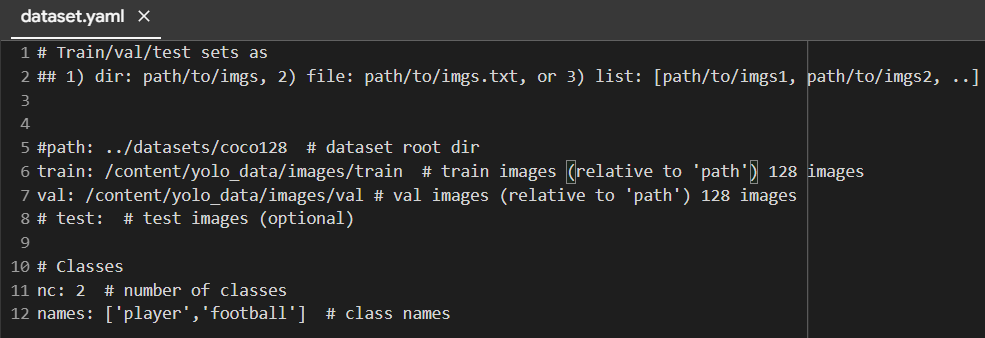

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.7 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.8/78.2 GB disk)


## Training

In [ ]:
!yolo task=detect mode=train model=yolov8l.pt data=/content/drive/MyDrive/yolov8/dataset.yaml epochs=50 imgsz=640 batch=8 project=/content/drive/MyDrive/yolov8/training_results name=wastePile

Ultralytics YOLOv8.1.7 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/drive/MyDrive/yolov8/dataset.yaml, epochs=50, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/yolov8/training_results, name=wastePile9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fal

In [ ]:
import pandas as pd

# Load the CSV file
results_csv_path = '/content/drive/MyDrive/yolov8/training_results/wastePile/results.csv'
results = pd.read_csv(results_csv_path)

# Print the column names
print("Column names in the CSV file:")
print(results.columns)

Column names in the CSV file:
Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')


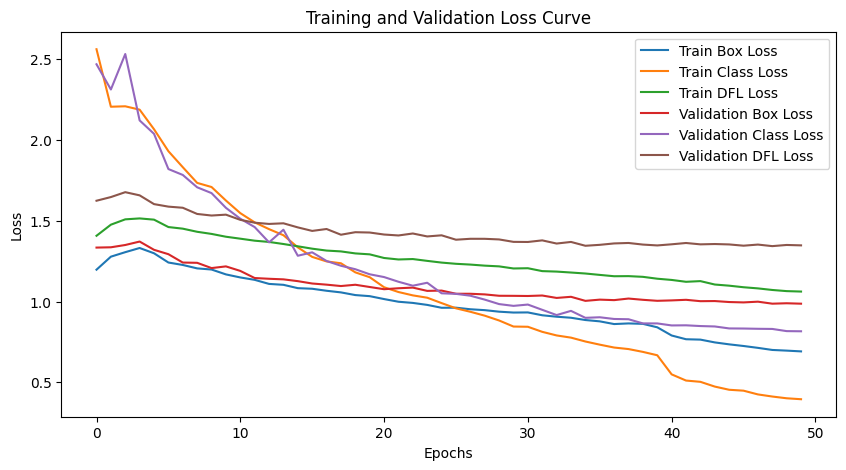

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_loss_curve(results_file):
    if os.path.exists(results_file):
        # Load results using Pandas
        results = pd.read_csv(results_file)

        # Strip leading spaces in column names
        results.columns = results.columns.str.strip()

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.title("Training and Validation Loss Curve")
        plt.plot(results['train/box_loss'], label='Train Box Loss')
        plt.plot(results['train/cls_loss'], label='Train Class Loss')
        plt.plot(results['train/dfl_loss'], label='Train DFL Loss')
        plt.plot(results['val/box_loss'], label='Validation Box Loss')
        plt.plot(results['val/cls_loss'], label='Validation Class Loss')
        plt.plot(results['val/dfl_loss'], label='Validation DFL Loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    else:
        print("Results file not found. Make sure the correct path is provided.")

# Example usage
results_csv_path = '/content/drive/MyDrive/yolov8/training_results/wastePile9/results.csv'
plot_loss_curve(results_csv_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File found at: /content/drive/MyDrive/yolov8/training_results/wastePile/results.csv


## Inferencing

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/yolov8/training_results/wastePile9/weights/best.pt conf=0.55 source=/content/drive/MyDrive/yolov8/test_images

In [ ]:
!cp -r /content/runs/detect/predict5 /content/drive/MyDrive/yolov8/output

### inferencing on video


In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/yolov8/training_results/wastePile9/weights/best.pt conf=0.77 source=/content/drive/MyDrive/yolov8/Videos

Ultralytics YOLOv8.1.7 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43621257 parameters, 0 gradients, 164.9 GFLOPs

video 1/3 (1/256) /content/drive/MyDrive/yolov8/Videos/IMG_4797.MOV: 640x384 1 aluminum - Non_biodegradable-Recyclable, 1 food wrapper - Non_Biodegradable, 2 pet bottle - Non_Biodegradable-Recyclables, 69.4ms
video 1/3 (2/256) /content/drive/MyDrive/yolov8/Videos/IMG_4797.MOV: 640x384 1 aluminum - Non_biodegradable-Recyclable, 1 food wrapper - Non_Biodegradable, 2 pet bottle - Non_Biodegradable-Recyclables, 39.7ms
video 1/3 (3/256) /content/drive/MyDrive/yolov8/Videos/IMG_4797.MOV: 640x384 1 aluminum - Non_biodegradable-Recyclable, 1 food wrapper - Non_Biodegradable, 2 pet bottle - Non_Biodegradable-Recyclables, 39.6ms
video 1/3 (4/256) /content/drive/MyDrive/yolov8/Videos/IMG_4797.MOV: 640x384 1 aluminum - Non_biodegradable-Recyclable, 1 food wrapper - Non_Biodegradable, 2 pet bottle - Non_Biodegradable-Recyclables, 39

In [ ]:
!cp -r /content/runs/detect/predict /content/drive/MyDrive/yolov8/output

In [ ]:
# !yolo task=detect mode=predict model=/content/drive/MyDrive/yolov8/training_results/football2/weights/best.pt conf=0.5 source=/content/drive/MyDrive/yolov8/videos

In [ ]:
# !cp -r /content/runs/detect/predict3 /content/drive/MyDrive/yolov8/output

In [ ]:
!yolo val model=/content/drive/MyDrive/yolov8/training_results/wastePile9/weights/best.pt data=/content/drive/MyDrive/yolov8/dataset.yaml


Ultralytics YOLOv8.1.7 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43621257 parameters, 0 gradients, 164.9 GFLOPs
val: Scanning /content/yolo_data/labels/val.cache... 602 images, 0 backgrounds, 0 corrupt: 100% 602/602 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 38/38 [00:32<00:00,  1.16it/s]
                   all        602       5230      0.831      0.733      0.817      0.589
aluminum - Non_biodegradable-Recyclable        602        369       0.87      0.848      0.913      0.693
cardboard - Non_Biodegradable-Recyclable        602        327      0.834      0.746      0.817      0.628
egg shell - Biodegradable        602        245      0.954      0.878      0.951      0.573
facemask - Non_Biodegradable        602        260      0.953      0.776      0.878      0.663
food wrapper - Non_Biodegradable        602        252      0.765      0.774      0.836      0.6

In [ ]:
!cp -r /content/runs/detect/val /content/drive/MyDrive/yolov8/training_results/wastePile9

## Export the model -- In progress

Export a YOLOv8 model to any supported format with the `format` argument, i.e. `format=onnx`.

Format                  | `format=...**bold text**`         | Model
---                     | ---                       | ---
PyTorch                 | -                         | yolov8n.pt
TorchScript             | `torchscript`             | yolov8n.torchscript
ONNX                    | `onnx`                    | yolov8n.onnx
OpenVINO                | `openvino`                | yolov8n_openvino_model/
TensorRT                | `engine`                  | yolov8n.engine
CoreML                  | `coreml`                  | yolov8n.mlmodel
TensorFlow SavedModel   | `saved_model`             | yolov8n_saved_model/
TensorFlow GraphDef     | `pb`                      | yolov8n.pb
TensorFlow Lite         | `tflite`                  | yolov8n.tflite
TensorFlow Edge TPU     | `edgetpu`                 | yolov8n_edgetpu.tflite
TensorFlow.js           | `tfjs`                    | yolov8n_web_model/
PaddlePaddle            | `paddle`                  | yolov8n_paddle_model/

In [ ]:
!yolo mode=export model=/content/drive/MyDrive/yolov8/training_results/wastePile9/weights/best.pt


Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 5, in <module>
    from ultralytics.cfg import entrypoint
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/__init__.py", line 5, in <module>
    from ultralytics.data.explorer.explorer import Explorer
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/data/explorer/__init__.py", line 3, in <module>
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/data/explorer/utils.py", line 8, in <module>
    import pandas as pd
  File "/usr/local/lib/python3.10/dist-packages/pandas/__init__.py", line 48, in <module>
    from pandas.core.api import (
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/api.py", line 27, in <module>
    from pandas.core.arrays import Categorical
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/__init__.py", line 1, in <module>
    from pandas.core.arrays.arrow import ArrowExtensionArray
  File "/usr/local/lib/python3.10/dist-packages/pandas/cor

NameError: name 'train_img_path' is not defined